In [29]:
%matplotlib inline
import matplotlib.image as mpimg
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from utils import read_all_images, img_crop
from augmentation import augment_data, rot90, rot180, rot270, fliph, flipv, flipvh
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Goodluck")

device = torch.device(device)

# Dataset loading

In [3]:
IMAGE_SRC_DIR = "training/images/"
IMAGE_GT_DIR = "training/groundtruth/"

IMAGES_SRC = np.asarray(read_all_images(IMAGE_SRC_DIR))
IMAGES_GT = np.asarray(read_all_images(IMAGE_GT_DIR))

IMAGES_SRC.shape

(100, 400, 400, 3)

# Augment data

Testing multiple examples

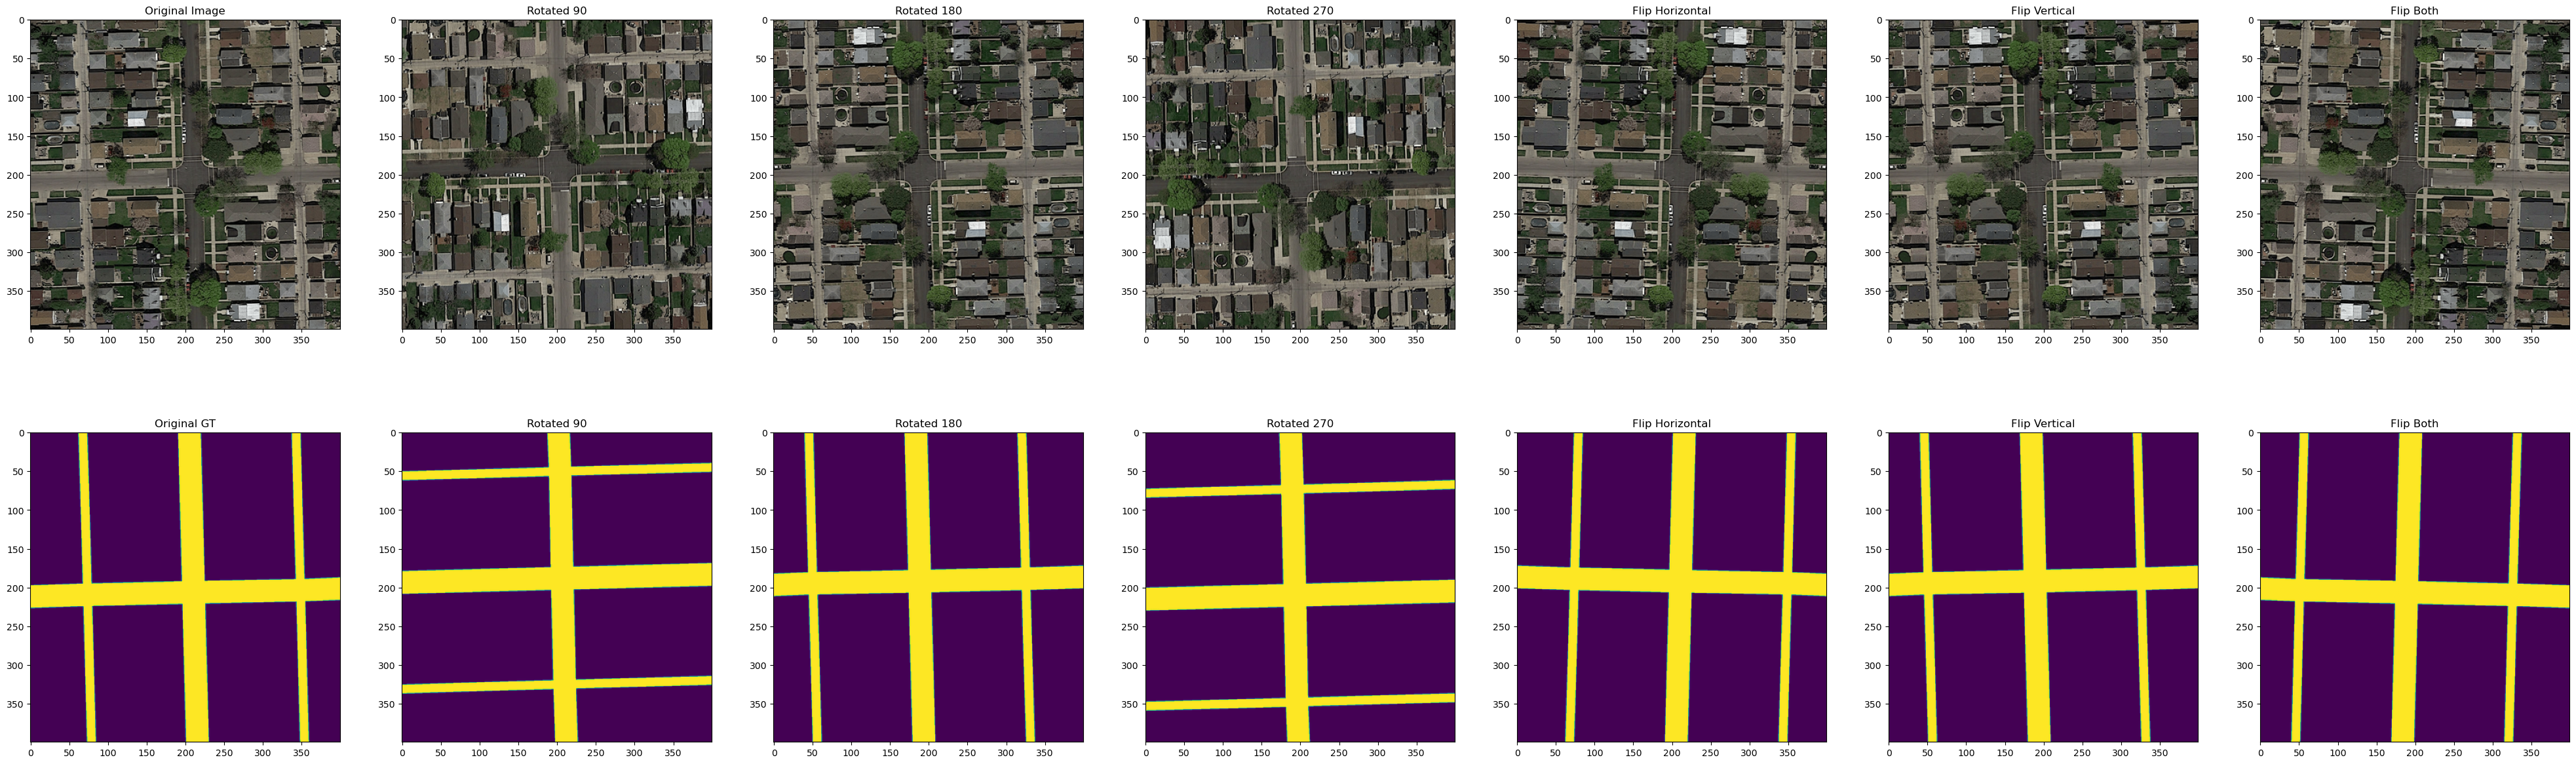

In [4]:
def visualize_augmented_data():
  rot90_images, rot90_gt = rot90(IMAGES_SRC, IMAGES_GT)
  rot180_images, rot180_gt = rot180(IMAGES_SRC, IMAGES_GT)
  rot270_images, rot270_gt = rot270(IMAGES_SRC, IMAGES_GT)
  fliph_images, fliph_gt = fliph(IMAGES_SRC, IMAGES_GT)
  flipv_images, flipv_gt = flipv(IMAGES_SRC, IMAGES_GT)
  flipvh_images, flipvh_gt = flipvh(IMAGES_SRC, IMAGES_GT)
  fig = plt.figure(figsize=(50, 15))
  fig.add_subplot(2, 7, 1)
  plt.imshow(IMAGES_SRC[0])
  plt.title("Original Image")
  fig.add_subplot(2, 7, 2)
  plt.imshow(rot90_images[0])
  plt.title("Rotated 90")
  fig.add_subplot(2, 7, 3)
  plt.imshow(rot180_images[0])
  plt.title("Rotated 180")
  fig.add_subplot(2, 7, 4)
  plt.imshow(rot270_images[0])
  plt.title("Rotated 270")
  fig.add_subplot(2, 7, 5)
  plt.imshow(fliph_images[0])
  plt.title("Flip Horizontal")
  fig.add_subplot(2, 7, 6)
  plt.imshow(flipv_images[0])
  plt.title("Flip Vertical")
  fig.add_subplot(2, 7, 7)
  plt.imshow(flipvh_images[0])
  plt.title("Flip Both")
  fig.add_subplot(2, 7, 8)
  plt.imshow(IMAGES_GT[0])
  plt.title("Original GT")
  fig.add_subplot(2, 7, 9)
  plt.imshow(rot90_gt[0])
  plt.title("Rotated 90")
  fig.add_subplot(2, 7, 10)
  plt.imshow(rot180_gt[0])
  plt.title("Rotated 180")
  fig.add_subplot(2, 7, 11)
  plt.imshow(rot270_gt[0])
  plt.title("Rotated 270")
  fig.add_subplot(2, 7, 12)
  plt.imshow(fliph_gt[0])
  plt.title("Flip Horizontal")
  fig.add_subplot(2, 7, 13)
  plt.imshow(flipv_gt[0])
  plt.title("Flip Vertical")
  fig.add_subplot(2, 7, 14)
  plt.imshow(flipvh_gt[0])
  plt.title("Flip Both")
  plt.show()

visualize_augmented_data()


In [5]:
augmented_src, augmented_gt = augment_data(IMAGES_SRC, IMAGES_GT)
print(augmented_src.shape)
print(augmented_gt.shape)

(600, 400, 400, 3)
(600, 400, 400)


## crop

In [6]:
PATCH_SIZE = 200
cropped_src, cropped_gt = np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src]).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)), np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt]).reshape((-1, PATCH_SIZE, PATCH_SIZE))
print(cropped_src.shape)
print(cropped_gt.shape)

(2400, 200, 200, 3)
(2400, 200, 200)


# Dataset loading

In [7]:
ds_src, ds_gt = torch.stack([transforms.ToTensor()(i) for i in cropped_src]), torch.stack([transforms.ToTensor()(i) for i in cropped_gt]).squeeze()
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([2400, 3, 200, 200])
torch.Size([2400, 200, 200])


In [8]:
dataset = TensorDataset(ds_src, ds_gt)

## + splitting

In [9]:
def split_dataset(dataset):
  train_size = int(len(dataset) * 0.9)
  test_size = len(dataset) - train_size
  return torch.utils.data.random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(dataset)

# Model definition

In [10]:
class FCN(nn.Module):
    def __init__(self, refinement_layers=3):
        super(FCN, self).__init__()
        self.refinement_layers = refinement_layers

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),

        )

        self.unconv = nn.Sequential(
            nn.ConvTranspose2d(64, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_conv2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_conv3 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_conv4 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_unconv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_unconv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_unconv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_unconv4 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.unconv(x)
        x = self.refinement_conv1(x)
        x = self.refinement_unconv1(x)
        x = self.refinement_conv2(x)
        x = self.refinement_unconv2(x)
        x = self.refinement_conv3(x)
        x = self.refinement_unconv3(x)
        x = self.refinement_conv4(x)
        x = self.refinement_unconv4(x)
        return x.squeeze()
    
summary(FCN(), input_size=(6, 3, PATCH_SIZE, PATCH_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [6, 200, 200]             --
├─Sequential: 1-1                        [6, 64, 50, 50]           --
│    └─Conv2d: 2-1                       [6, 16, 200, 200]         1,216
│    └─BatchNorm2d: 2-2                  [6, 16, 200, 200]         32
│    └─MaxPool2d: 2-3                    [6, 16, 100, 100]         --
│    └─LeakyReLU: 2-4                    [6, 16, 100, 100]         --
│    └─Conv2d: 2-5                       [6, 64, 100, 100]         25,664
│    └─BatchNorm2d: 2-6                  [6, 64, 100, 100]         128
│    └─MaxPool2d: 2-7                    [6, 64, 50, 50]           --
│    └─LeakyReLU: 2-8                    [6, 64, 50, 50]           --
├─Sequential: 1-2                        [6, 1, 200, 200]          --
│    └─ConvTranspose2d: 2-9              [6, 16, 100, 100]         16,400
│    └─LeakyReLU: 2-10                   [6, 16, 100, 100]         --
│  

# Training!

In [11]:
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append(((output > 0.5).eq(target > 0.5).sum() / target.numel()).item())

    return acc_history, loss_history

In [12]:
def train(device, epochs = 60):
    pytorchDl = DataLoader(train_ds,batch_size = 32,shuffle=True)
    model = FCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.functional.binary_cross_entropy

    for i in range(epochs):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        if i % 5 == 0:
            print("saving…")
            torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

    return model

def resume(device, saved_epoch, max_epochs):
    pytorchDl = DataLoader(train_ds,batch_size = 32,shuffle=True)
    model = FCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.functional.binary_cross_entropy
    model.load_state_dict(torch.load("./checkpoint_{}.pth".format(saved_epoch)))

    for i in range(saved_epoch, max_epochs):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        if i % 5 == 0:
            print("saving…")
            torch.save(model.state_dict(), "./checkpoint_{}.pth".format(i))
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

    return model

# Let's play!

In [58]:
model = train(device, 300)

saving…
Epoch:  0  Accuracy:  0.7606819894383935  Loss:  0.40170517213204326
Epoch:  1  Accuracy:  0.7294744051554624  Loss:  0.3325852558893316
Epoch:  2  Accuracy:  0.729360399000785  Loss:  0.303077324786607
Epoch:  3  Accuracy:  0.7343459962045445  Loss:  0.28928018755772533
Epoch:  4  Accuracy:  0.7378586793647093  Loss:  0.2681852901244865
saving…
Epoch:  5  Accuracy:  0.7405457742073956  Loss:  0.2555333533707787
Epoch:  6  Accuracy:  0.7445541988400852  Loss:  0.24250633554423556
Epoch:  7  Accuracy:  0.7472172458382214  Loss:  0.233776235843406
Epoch:  8  Accuracy:  0.7494512805167366  Loss:  0.221850716673276
Epoch:  9  Accuracy:  0.7496786257799934  Loss:  0.2128702875445871
saving…
Epoch:  10  Accuracy:  0.7503584053586511  Loss:  0.21198580677018447
Epoch:  11  Accuracy:  0.7532732320182464  Loss:  0.1997421550400117
Epoch:  12  Accuracy:  0.7510864945018992  Loss:  0.2024155815734583
Epoch:  13  Accuracy:  0.7545375289285884  Loss:  0.19184084477670052
Epoch:  14  Accurac

KeyboardInterrupt: 

In [33]:
model = resume(device, 165, 201)

saving…
Epoch:  165  Accuracy:  0.9754849610959783  Loss:  0.0998456365264514
Epoch:  166  Accuracy:  0.9758258269113653  Loss:  0.0986253813128261
Epoch:  167  Accuracy:  0.9782407380202237  Loss:  0.09410861145485849
Epoch:  168  Accuracy:  0.9776517661178813  Loss:  0.09515323840519961
Epoch:  169  Accuracy:  0.9775452061611063  Loss:  0.09518393644076936
saving…
Epoch:  170  Accuracy:  0.976529903271619  Loss:  0.09730705739382435
Epoch:  171  Accuracy:  0.9771181046962738  Loss:  0.09603609287125223
Epoch:  172  Accuracy:  0.9760507240014917  Loss:  0.09804520832703394
Epoch:  173  Accuracy:  0.977742430041818  Loss:  0.0947073166642119
Epoch:  174  Accuracy:  0.9783056518610787  Loss:  0.09377419992404826
saving…
Epoch:  175  Accuracy:  0.9796953928821227  Loss:  0.0910801993792548
Epoch:  176  Accuracy:  0.980009913444519  Loss:  0.09046318929861574
Epoch:  177  Accuracy:  0.977546379846685  Loss:  0.09507281475645654
Epoch:  178  Accuracy:  0.978922047159251  Loss:  0.092521995

# Visualize results?

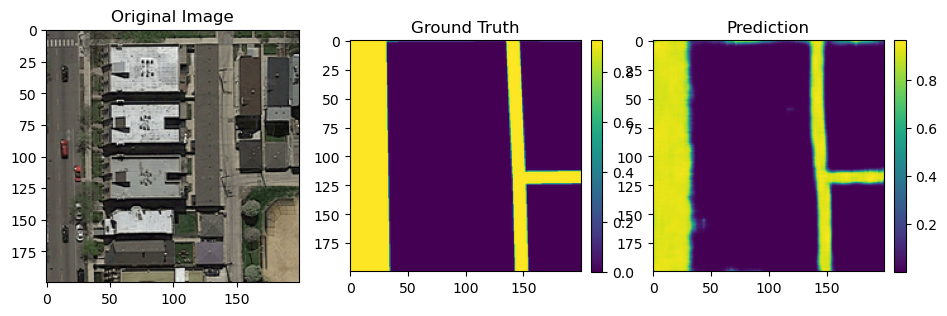

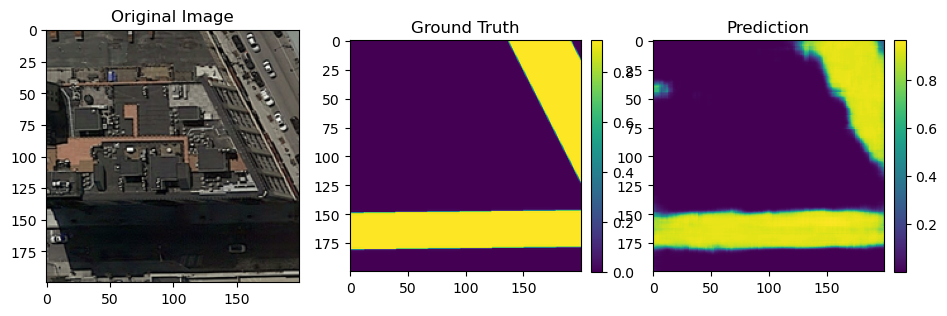

In [41]:
def visualize_result(device, model, dataset):
  model.eval()
  pytorchDl = DataLoader(dataset,batch_size = 1,shuffle=True)
  for data, target in pytorchDl:
    data = data.squeeze()
    target = target.squeeze()
    output = model.forward(data.to(device).unsqueeze(0))
    data, target = data.cpu().numpy().transpose((1, 2, 0)), target.cpu().numpy()

    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 4, 1)
    im = plt.imshow(data)
    plt.title("Original Image")
    fig.add_subplot(1, 4, 2)
    im = plt.imshow(target)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")
    fig.add_subplot(1, 4, 3)
    im = plt.imshow((output).cpu().detach().numpy())
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prediction")
    plt.show()
    break

visualize_result(device, model, train_ds)
visualize_result(device, model, test_ds)



# Making a submission

In [40]:
from mask_to_submission import masks_to_submission
from utils import img_float_to_uint8, load_image


TEST_SET_FOLDER = "test_set_images/"
SUBMISSION_NAME = "caca_3.csv"
NUMBER_OF_TEST = 50

for i in range(1, NUMBER_OF_TEST+1):
  img = load_image(TEST_SET_FOLDER + "test_" + str(i) + "/" + "test_" + str(i) + ".png")
  img = transforms.ToTensor()(img).to(device)
  model.eval()
  output = model.to(device)(img.unsqueeze(0)).cpu().detach().numpy()
  output = img_float_to_uint8(output.squeeze())
  output_image = Image.fromarray(output)
  output_image.save("submission/" + str(i) + ".png")

masks_to_submission(SUBMISSION_NAME, *["submission/" + str(i) + ".png" for i in range(1, NUMBER_OF_TEST+1)])